In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn import metrics as mt
from sklearn.metrics import roc_curve, auc
import operator
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KDTree

### Functions for ROC stuff

In [2]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
#probs is the result of a model.predict_proba(x_test) call

#This function plots an ROC curve
def rocCurvePlot(probs, y_test1):
    # calculate the fpr and tpr for all thresholds of the classification
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test1, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
# A function to find the optimal cutoff point from ROC curve

#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """Parameters:
    target : Matrix with dependent or target data, where rows are observations
    predicted : Matrix with predicted data, where rows are observations
    ----------
    Return: list type, with optimal cutoff value
    """
    predicted = predicted[:,1]
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

### Import the data

In [3]:
directory = 'C:/githubrepo/7331_Project/data/'
df_zg = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
print("Done reading data.")

Done reading data.


### Make diabetesMed binary instead of yes/no

In [4]:
#can also use binary encoder to achieve this
df_zg.diabetesMed[df_zg.diabetesMed == 'No'] = 0
df_zg.diabetesMed[df_zg.diabetesMed == 'Yes'] = 1

df_zg["diabetesMed"] = df_zg["diabetesMed"].astype(int)

### Makes lists of the different types

In [5]:
ordinal = ["age", "time_in_hospital"]
categorical = ["race", "gender", "admission_type_id", "discharge_disposition_id",
               "admission_source_id", "medical_specialty", "max_glu_serum",
               "A1Cresult", "change", "diabetesMed", "diag_1_val", "diag_2_val",
               "diag_3_val", "meds_increased"]
continuous = ["num_lab_procedures", "num_procedures", "num_medications",
              "number_outpatient", "number_emergency", "number_inpatient",
              "number_diagnoses", "medication_count"]
lcontinuous = ["lnum_lab_procedures", "lnum_procedures", "lnum_medications",
              "lnumber_outpatient", "lnumber_emergency", "lnumber_inpatient",
              "lnumber_diagnoses", "lmedication_count"]
medicines = ["metformin", "repaglinide", "nateglinide", "chlorpropamide",
             "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             "tolazamide", "insulin", "glyburide-metformin", "glipizide-metformin",
             "metformin-rosiglitazone", "metformin-pioglitazone"]
response = ["readmitted_tf"]

### Dataframes of each type of data

In [6]:
df_zg_ordinal = df_zg[ordinal]
df_zg_categorical = df_zg[categorical]
df_zg_continuous = df_zg[continuous]
df_zg_lcontinuous = np.log(df_zg_continuous)
df_zg_lcontinuous.columns = lcontinuous
df_zg_medicines = df_zg[medicines]
df_zg_response = df_zg[response]

### Make Age ordinal

In [7]:
for i in range(0, 10):
    val = "[" + str(i*10) + "-" + str((i+1)*10) + ")"
    df_zg_ordinal.loc[df_zg_ordinal['age'] == val, 'age'] = i

### Making all categorical columns categorical

In [8]:
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['discharge_disposition_id'] = df_zg_categorical['discharge_disposition_id'].astype(object)
df_zg_categorical['admission_source_id'] = df_zg_categorical['admission_source_id'].astype(object)
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['meds_increased'] = df_zg_categorical['meds_increased'].astype(int)
#df_zg_response['readmitted_tf'] = df_zg_response['readmitted_tf'].astype(object)
print("Done")

Done


In [9]:
df_zg_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous], axis = 1)
df_zg_num_x = pd.concat([df_zg_ordinal, df_zg_continuous], axis = 1)
df_zg_med_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous, df_zg_medicines], axis = 1)
df_zg_hot_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous], axis = 1)
df_zg_hot_med_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous, pd.get_dummies(df_zg_medicines)], axis = 1)
df_zg_y = df_zg_response
print("Done")

Done


### Function for setting up the training, validation, and test sets

In [10]:
def tvt_split(df_x, df_y, valid_size, t_size, seed):
    #doing the math because we have to split 2 seperate times
    valid_size = 100*valid_size/(100*(1-t_size))
    #First splitting out the test set
    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = t_size, random_state=seed)
    #Splitting the training set into train/validate
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = valid_size, random_state=seed)

    #Reseting allof the indices
    x_train.reset_index()
    y_train.reset_index()
    x_test.reset_index()
    y_test.reset_index()
    x_valid.reset_index()
    y_valid.reset_index()

    return x_train, x_valid, x_test, y_train, y_valid, y_test

# KNN with variables based on T-scores

### Make dataframe of columns that had 10 highest T-scores

In [46]:
nm = ["admission_source_id", "medical_specialty", "admission_type_id",
      "discharge_disposition_id", "number_inpatient", "number_emergency",
      "meds_increased", "number_outpatient", "num_lab_procedures", "time_in_hospital"]
df_zg_minPCA = df_zg[nm]
df_zg_minPCA = pd.get_dummies(df_zg_minPCA)

scl = StandardScaler()
df_zg_PCA_scl = scl.fit_transform(df_zg_minPCA)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Do the split again, just for safety

In [47]:
%%time
x_train, x_valid, x_test, y_train, y_valid, y_test = tvt_split(df_zg_minPCA, df_zg_y, 0.2, 0.2, 7)

#Print out the shapes of the train/valid/test sets
x_train.shape, x_valid.shape, x_test.shape

#Create variables for just this operation
x_t = x_train
x_v = x_valid
y_t = y_train
y_v = y_valid
y_tst = y_test

# We will fill this with predictions
yhat = np.zeros(y_v.shape)

scl = StandardScaler()
x_t = scl.fit_transform(x_train)
x_v = scl.transform(x_valid)
x_tst = scl.transform(x_test)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Wall time: 518 ms


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


### KNN with t-statistic variables
Now that we have tuned the values for K, we do the prediction on the test set. Below shows the ROC curve with all of the accuracy metrics and confusion matrix.

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


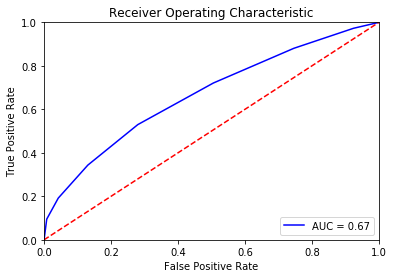

F1: 0.6287 ACC: 0.6323 AUC: 0.6677
Specificity: 0.5298 Sensitivity: 0.72

Confusion Matrix
 [[7898 3071]
 [4413 4972]]
Wall time: 6min 6s


In [49]:
%%time
clf = KNeighborsClassifier(n_neighbors = 7)
clf.fit(x_t, y_t)

#Find the optimal cutoff point
y_pred_cut = clf.predict_proba(x_v)
cutoff = Find_Optimal_Cutoff(y_v, y_pred_cut)

#Prediction
y_pred_probs = clf.predict_proba(x_tst)
y_pred = np.where(y_pred_probs >= cutoff, 1, 0)
y_pred = y_pred[:,1]

rocCurvePlot(y_pred_probs, y_tst)

#Accuracy metrics
f1 = f1_score(y_tst, y_pred, average = 'weighted')
acc = accuracy_score(y_tst, y_pred)
auc = roc_auc_score(y_tst, y_pred_probs[:,1])
conf = mt.confusion_matrix(y_tst, y_pred)
sens = conf[0,0]/(conf[0,0] + conf[0,1])
spec = conf[1,1]/(conf[1,0] + conf[1,1])
print("F1:", round(f1,4), "ACC:", round(acc,4), "AUC:", round(auc,4))
print("Specificity:", round(spec, 4), "Sensitivity:", round(sens, 4))
print("\nConfusion Matrix\n", conf)
y_pred_tstat = y_pred

# KNN with variables based on Correlation

In [51]:
nm = ["num_medications", "number_diagnoses", "admission_source_id", "time_in_hospital",
      "admission_source_id", "number_emergency", "num_lab_procedures", "admission_type_id",
      "number_inpatient", "discharge_disposition_id"]
df_zg_minPCA = df_zg[nm]
df_zg_minPCA = pd.get_dummies(df_zg_minPCA)

In [52]:
%%time
x_train, x_valid, x_test, y_train, y_valid, y_test = tvt_split(df_zg_minPCA, df_zg_y, 0.2, 0.2, 7)

#Create variables for just this operation
x_t = x_train
x_v = x_valid
y_t = y_train
y_v = y_valid
y_tst = y_test

# We will fill this with predictions
yhat = np.zeros(y_v.shape)

scl = StandardScaler()
x_t = scl.fit_transform(x_train)
x_v = scl.transform(x_valid)
x_tst = scl.transform(x_test)

#Print out the shapes of the train/valid/test sets
x_train.shape, x_valid.shape, x_test.shape

Wall time: 87.7 ms


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [53]:
x_train.shape, x_valid.shape, x_test.shape

((61059, 10), (20353, 10), (20354, 10))

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


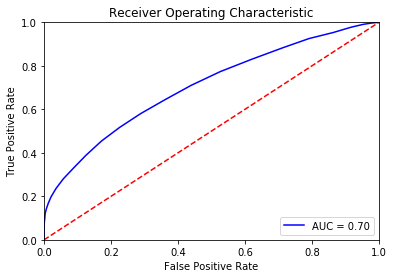

F1: 0.6418684651822801 ACC: 0.6413481379581409 AUC: 0.7042891885025135 
Confusion Matrix
 [[7006 3963]
 [3337 6048]]
Wall time: 16.2 s


In [54]:
%%time
# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors = 27)
clf.fit(x_t, y_t)

#Find the optimal cutoff point
y_pred_cut = clf.predict_proba(x_v)
cutoff = Find_Optimal_Cutoff(y_v, y_pred_cut)

#Prediction
#y_pred = model.predict(x_test_scaled)
y_pred_probs = clf.predict_proba(x_tst)
y_pred = np.where(y_pred_probs >= cutoff, 1, 0)
y_pred = y_pred[:,1]

rocCurvePlot(y_pred_probs, y_tst)

#Accuracy metrics
f1 = f1_score(y_tst, y_pred, average = 'weighted')
acc = accuracy_score(y_tst, y_pred)
roc = roc_auc_score(y_tst, y_pred_probs[:,1])
#roc = roc_auc_score(y_v, clf.predict_proba(x_v)[:,1])
conf = mt.confusion_matrix(y_tst, y_pred)
print("F1:", f1, "ACC:", acc, "AUC:", roc, "\nConfusion Matrix\n", conf)
y_pred_corr = y_pred

# KNN with variables based on Full Model

In [55]:
%%time
x_train, x_valid, x_test, y_train, y_valid, y_test = tvt_split(df_zg_hot_x, df_zg_y, 0.2, 0.2, 7)

#Print out the shapes of the train/valid/test sets
x_train.shape, x_valid.shape, x_test.shape

#Create variables for just this operation
x_t = x_train
x_v = x_valid
y_t = y_train
y_v = y_valid
y_tst = y_test

# We will fill this with predictions
yhat = np.zeros(y_v.shape)

scl = StandardScaler()
x_t = scl.fit_transform(x_train)
x_v = scl.transform(x_valid)
x_tst = scl.transform(x_test)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.


Wall time: 1.27 s


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


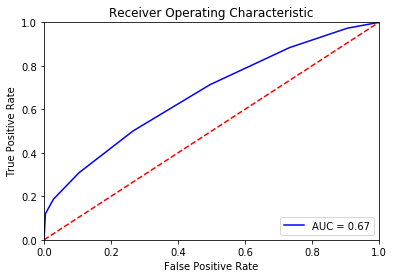

F1: 0.621 ACC: 0.6265 AUC: 0.6706
Specificity: 0.5009 Sensitivity: 0.734

Confusion Matrix
 [[8051 2918]
 [4684 4701]]
Wall time: 15min 23s


In [20]:
%%time
clf = KNeighborsClassifier(n_neighbors = 7)
clf.fit(x_t, y_t)

#Find the optimal cutoff point
y_pred_cut = clf.predict_proba(x_v)
cutoff = Find_Optimal_Cutoff(y_v, y_pred_cut)

#Prediction
y_pred_probs = clf.predict_proba(x_tst)
y_pred = np.where(y_pred_probs >= cutoff, 1, 0)
y_pred = y_pred[:,1]

rocCurvePlot(y_pred_probs, y_tst)

#Accuracy metrics
f1 = f1_score(y_tst, y_pred, average = 'weighted')
acc = accuracy_score(y_tst, y_pred)
auc = roc_auc_score(y_tst, y_pred_probs[:,1])
conf = mt.confusion_matrix(y_tst, y_pred)
sens = conf[0,0]/(conf[0,0] + conf[0,1])
spec = conf[1,1]/(conf[1,0] + conf[1,1])
print("F1:", round(f1,4), "ACC:", round(acc,4), "AUC:", round(auc,4))
print("Specificity:", round(spec, 4), "Sensitivity:", round(sens, 4))
print("\nConfusion Matrix\n", conf)
y_pred_full = y_pred

# Ensemble Model from the three KNN's

In [56]:
from operator import add
vals = list( map(add, y_pred_full, y_pred_tstat) )
vals = np.asarray(list( map(add, vals, y_pred_corr) ))
y_pred_all = np.where(vals >= 2, 1, 0)

#Accuracy metrics
f1 = f1_score(y_tst, y_pred_all, average = 'weighted')
acc = accuracy_score(y_tst, y_pred_all)
auc = roc_auc_score(y_tst, y_pred_all)
conf = mt.confusion_matrix(y_tst, y_pred_all)
sens = conf[0,0]/(conf[0,0] + conf[0,1])
spec = conf[1,1]/(conf[1,0] + conf[1,1])
print("F1:", round(f1,4), "ACC:", round(acc,4), "AUC:", round(auc,4))
print("Specificity:", round(spec, 4), "Sensitivity:", round(sens, 4))
print("\nConfusion Matrix\n", conf)

F1: 0.6553 ACC: 0.658 AUC: 0.6514
Specificity: 0.5661 Sensitivity: 0.7366

Confusion Matrix
 [[8080 2889]
 [4072 5313]]
